# Business Problem

A new bitcoin millionaire wants to get into flipping houses in the Seattle area.

They have approached our company asking us to build a model to predict a homes' sale price. They want to use that prediction to determine if they should buy a home currently for sale with the intent to renovate it and flip it for profit.

**Here where we say renovate we mean to restore quality, not to be confused with remodel, where we add/remove features**

The idea is that there are currently homes for sale, and our model is to predict the price when the condition of the home is improved. 


---------------------------------------------

Our business problem . 
- First we will do data exploration to see what we have that we are working with.
- Build a baseline model with all the features and see how accurate it is
- See if condition is a feature that impacts price first?

------------------------------

We are provided with data from another company that represents housing information for Kings County (where Seattle is located) to build our model.

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, ShuffleSplit

import statsmodels.api as sm
import statsmodels.formula.api as smf


raw_data = pd.read_csv('data\kc_house_data.csv')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [2]:
raw_data.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

As we do our data exploration, we will make sure to deal with these null values. For now, we will make a copy of the raw data as our working dataframe, df.

In [3]:
df = raw_data.copy()

# Investigating each feature

## 'id'

Dropping the 'id' column, this is a unique identifier that we will not be using in any analysis/modeling.

In [4]:
df.drop(['id'], axis=1, inplace=True)

## 'date'

First we will convert the column to a datetime object

In [5]:
df.date = pd.to_datetime(df.date)

In [6]:
df.date.describe(datetime_is_numeric=True)

count                            21597
mean     2014-10-29 04:20:38.171968512
min                2014-05-02 00:00:00
25%                2014-07-22 00:00:00
50%                2014-10-16 00:00:00
75%                2015-02-17 00:00:00
max                2015-05-27 00:00:00
Name: date, dtype: object

The sale dates range from 5/2/2014 to 5/27/2015.

Having this feature as a datetime object will allow for additional feature engineering later on.

## 'price' **(TARGET)**

In [7]:
df.price.describe().round()

count      21597.0
mean      540297.0
std       367368.0
min        78000.0
25%       322000.0
50%       450000.0
75%       645000.0
max      7700000.0
Name: price, dtype: float64

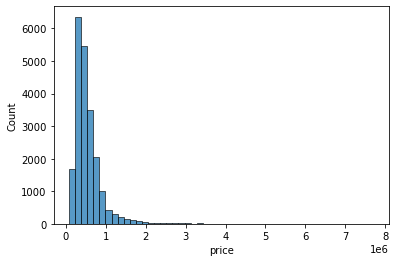

In [8]:
sns.histplot(data=df, x='price', bins=50);

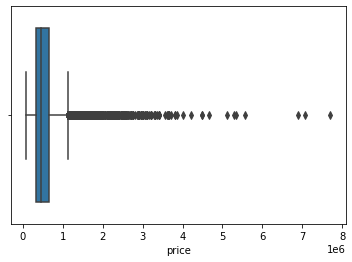

In [9]:
sns.boxplot(data=df, x='price');

The price data is heavily right skewed. Our average home price is \\$540k, it looks like lots of homes sell for under \\$100k. But there are enough homes that sell for over \\$500k to push the average up.

> We may need to consider scaling and normalizing later?

## 'bedrooms'


In [10]:
df.bedrooms.describe()

count    21597.000000
mean         3.373200
std          0.926299
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

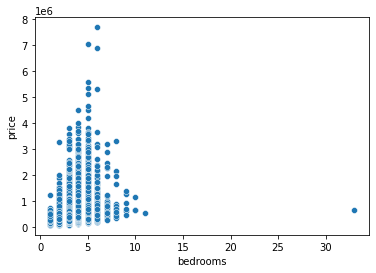

In [11]:
sns.scatterplot(data=df, x='bedrooms', y='price')

In [12]:
df.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
33       1
11       1
Name: bedrooms, dtype: int64

In [13]:
df[df.bedrooms == 33]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15856,2014-06-25,640000.0,33,1.75,1620,6000,1.0,NO,NONE,Very Good,7 Average,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700


This outlier in number of bedrooms is interesting. I doubt very much there are 33 bedrooms in a 1,000 ft$^{2}$ home. We suspect an entry error and are going change it to 3, which is much more likely.

In [14]:
df.at[15856,'bedrooms'] = 3

In [15]:
df.bedrooms.value_counts()

3     9825
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

The vast majority of homes are 4 bedrooms and under.

We are going to encode this variable by binning into:
- 1/2 bedrooms
- 3/4 bedrooms
- 5/6 bedrooms
- more than 6 bedrooms (this feature is dropped to prevent multicollinearity)

In [16]:
df['bedrooms_1_2'] = df.bedrooms.map(lambda x: 1 if x <= 2 else 0)
df['bedrooms_3_4'] = df.bedrooms.map(lambda x: 1 if ((x > 2) & (x <= 4)) else 0)
df['bedrooms_5_6'] = df.bedrooms.map(lambda x: 1 if ((x > 4) & (x <= 6)) else 0)

df.drop(['bedrooms'], axis=1, inplace=True)

## 'bathrooms'

In [17]:
df.bathrooms.describe()

count    21597.000000
mean         2.115826
std          0.768984
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64

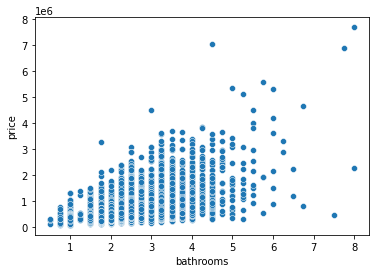

In [18]:
sns.scatterplot(data=df, x='bathrooms', y='price');

The range of values was unexpected. 

After some research, learned that a bathroom is considered 'full' with 4 parts, each worth a quarter:
- sink
- toilet
- shower
- bathtub

Based on the description of the data, we are going to encode the bathrooms by binning. Our average bathroom size is just over 2. We are going to bin into:
- 1 bathroom (x <= 1)
- 2 bathrooms (1 < x <= 2)
- 3 bathrooms (2 < x <= 3)
- more than 3 bathrooms (this is the feature that is dropped)

In [19]:
df['bathrooms_1'] = df.bathrooms.map(lambda x: 1 if x<=1 else 0)
df['bathrooms_3'] = df.bathrooms.map(lambda x: 1 if ((x>2)&(x<=3)) else 0)

In [20]:
df.drop(['bathrooms'], axis=1, inplace=True)

## 'sqft_living'

In [21]:
df.sqft_living.describe()

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

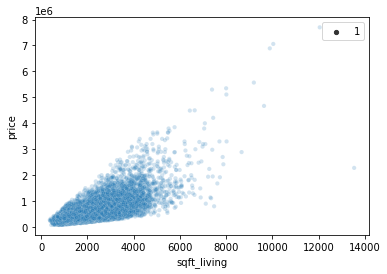

In [22]:
sns.scatterplot(data=df, x='sqft_living', y='price', size=1, alpha=0.2);

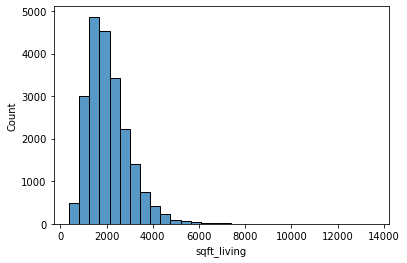

In [23]:
sns.histplot(data=df, x='sqft_living', bins=30);

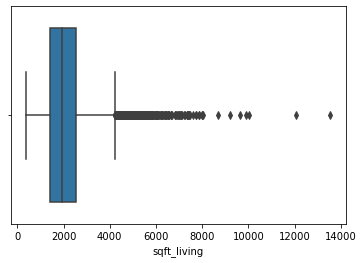

In [24]:
sns.boxplot(data=df, x='sqft_living');

In [25]:
len(df[df.sqft_living <= 4000])/len(df)

0.9637912673056444

57% of homes are have below the average of 2,080 ft$^{2}$.

96% of homes are below 4,000 ft$^{2}$.

The vast majority of our sqft_living data is grouped under 4,000 ft$^{2}$. There are some large homes out there, but our mean and median are pretty close (2,080 vs 1,910). The data looks normal except for the right skewedness.


Again, suspect that we have a subset of extremely large homes. This looks like a feature to use to restrict our dataset a bit to maybe improve the model? Maybe viewing large homes represented on a map vs all other sized homes will show neighborhoods that are more likely to hold large homes?

## 'sqft_lot'

In [26]:
df.sqft_lot.describe().round()

count      21597.0
mean       15099.0
std        41413.0
min          520.0
25%         5040.0
50%         7618.0
75%        10685.0
max      1651359.0
Name: sqft_lot, dtype: float64

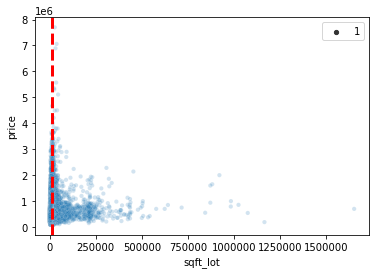

In [27]:
sns.scatterplot(data=df, x='sqft_lot', y='price', size=1, alpha=0.2)

plt.axvline(x=df.sqft_lot.mean(), color='red', ls='--', lw=3)

plt.ticklabel_format(style='plain', axis='x',useOffset=False);

Three quarters of our data on sqft_lot is under 10,000 ft$^{2}$, but the average lot is about 15,000 ft$^{2}$.

The large lot sizes are enormously large in comparison, and that may be fouling up our model later. This is another feature we may need to scale/normalize later on.

In [28]:
# sqft is easy to estimate for inside home size, but more difficult to get a
# sense for. If we later want to conver to acres, divide sqft by 43560
15099 / 43560

# our average lot size is 15,099 sqft, which is .35 acres

0.3466253443526171

In [29]:
len(df[df.sqft_lot < 15099])/len(df)

0.8519238783164328

85% of homes have a lot less than the average of 15,099 sqft. 

For now we are leaving everything in the baseline model, but this is a feature that may be dropped.

Lot size is not a guarantee of high home value. In fact, it looks like smaller lot sizes are **more** valuable than larger. Larger lots do not equal larger/more expensive homes, and also tend to be further from amenities.

I wonder if we should just drop it all together, or perhaps bin them? This also could possibly be log scaled?

## 'floors'

In [30]:
df.floors.describe()

count    21597.000000
mean         1.494096
std          0.539683
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64

<AxesSubplot:xlabel='floors', ylabel='Count'>

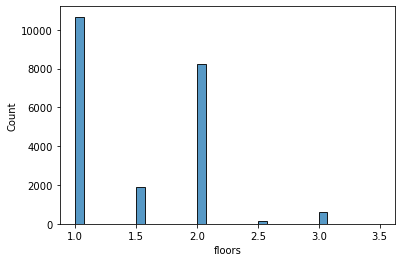

In [31]:
sns.histplot(data=df, x='floors')

A 1.5-storey house is a detached home that has a second floor that is about half the size of the main floor, but is off to one side.

Most of our data is 1 or 2 floor homes, but we have some 1.5, 2.5, 3 and 3.5 in there too.

We will bin the variable into:
- One floor (includes 1.5)
- Two floors (includes 2.5)
- Three floors (everything 3 and up, this one will be dropped)

In [32]:
df['floors_1'] = df.floors.map(lambda x: 1 if x<2 else 0)
df['floors_2'] = df.floors.map(lambda x: 1 if ((x>=2) & (x<3)) else 0)

In [33]:
df.drop(['floors'], axis=1, inplace=True)

## 'waterfront'

In importing we checked for null values, and there were some in the 'waterfront' feature.

In [34]:
df.waterfront.value_counts(normalize=True)

NO     0.992404
YES    0.007596
Name: waterfront, dtype: float64

There are only two options, waterfront or not. Less than 1% of homes are waterfront, so we assume that no value means no waterfront view, and set the value to 'NO'.

In [35]:
df['waterfront'].fillna('NO', inplace=True)

This is a simple categorical, if the home is considered waterfront or not. 

We will convert this to a numerical feature, YES being 1 and NO being 0.

In [36]:
# converted 'waterfront' feature (numeric boolean)
df['waterfront'] = df.waterfront.map({'NO': 0, 'YES': 1})

## 'view'

In checking for null values, we also have some in the 'view' feature.

In [37]:
df.view.value_counts(normalize=True)

NONE         0.901923
AVERAGE      0.044441
GOOD         0.023591
FAIR         0.015325
EXCELLENT    0.014721
Name: view, dtype: float64

The values are categorical, and over 90% of homes have a view value of 'NONE'. The 63 missing values will be set to 'NONE'.

In [38]:
df['view'].fillna('NONE', inplace=True)

The documentation describes this as the quality of view from a house. It will need to be converted to model.

One option is onehotencoding this feature, but 90% of this feature is 'NONE' (for no view), so instead we will convert this to a numerical boolean feature of 1 for having a view and 0 for not having a view.

In [39]:
# converted 'view' feature (numeric boolean)
df['view'] = df.view.map(lambda x: 0 if x == 'NONE' else 1)

## 'condition'

Documentation with the dataset explains this feature is the overall condition of the home relative to ongoing maintenance.

In [40]:
df.condition.value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

Referencing the documentation, the condition can be graded numerically:

{'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1}

We will need to convert this column before modeling.

In [41]:
# converted 'condition' feature
condition_dict = {'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2,
                  'Poor': 1}
df['condition'] = df.condition.map(condition_dict)

In [125]:
df.condition.describe()

count    21597.000000
mean         3.409825
std          0.650546
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: condition, dtype: float64

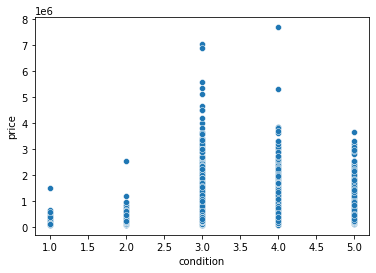

In [42]:
sns.scatterplot(data=df, x='condition', y='price');

We will onehotencode both condition and grade in section 3.12.1

## 'grade'

In [105]:
df.grade.value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [123]:
df['grade'] = df.grade.map(lambda x: x.split()[0]).astype('int')

In [124]:
df.grade.describe()

count    21597.000000
mean         7.657915
std          1.173200
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

This feature, per the documentation, is the overall grade of the home relative to construction/design. This is a separate feature than condition, but we will have to see if there is any multicollinearity here. It could certainly be the case that a high graded home (good quality construction or design) could be left to disrepair and have a poor condition value.

We will need to convert the column before modeling, we can just slice the string and take the first section, convert to numerical.

### onehotecode 'condition' & 'grade'

In [127]:
# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# create temporary dataframe df_test with condition and grade features in it
df_test = df[['condition', 'grade']].copy()

# create a onehotencoder, fit to df_test
ohe = OneHotEncoder().fit(df_test)

# create the array
onehotarray = ohe.transform(df_test).toarray()

# generate column_names to match values, 'feature_{value}'
column_names = []
for x in range(1,6):
    column_names.append(f'condition_{x}')
for x in range(3,14):
    column_names.append(f'grade_{x}')
    
# create dataframe of array with correct column names
ohe_df = pd.DataFrame(onehotarray, columns=column_names)

# remove the column representing feature average from the dataframe
ohe_df.drop(['condition_3', 'grade_7'], axis=1, inplace=True)

In [130]:
# concat the main dataframe df with the onehotencoded df we just made
df = pd.concat([df, ohe_df], axis=1)

# drop the original two features
df.drop(['condition', 'grade'], axis=1, inplace=True)

## 'sqft_above'

This is the square footage of the home apart from the basement. There is likely some multicollinearity with other features like 'sqft_living', and 'sqft_basement'.

In [133]:
df.sqft_above.describe()

count    21597.000000
mean      1788.596842
std        827.759761
min        370.000000
25%       1190.000000
50%       1560.000000
75%       2210.000000
max       9410.000000
Name: sqft_above, dtype: float64

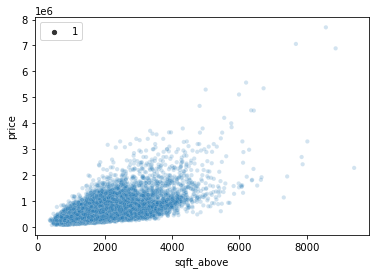

In [134]:
sns.scatterplot(data=df, x='sqft_above', y='price', size=1, alpha=0.2);

We will likely drop this feature to reduce multicollinearity. 

If we consider below that 60% of homes have no basement, then the relationship between 'sqft_living' and 'sqft_above' is likely very strong and probably experience high multicollinearity.

## 'sqft_basement'

In [135]:
df.sqft_basement.value_counts(normalize=True)

0.0       0.593879
?         0.021021
600.0     0.010048
500.0     0.009677
700.0     0.009631
            ...   
1245.0    0.000046
1990.0    0.000046
768.0     0.000046
2300.0    0.000046
2250.0    0.000046
Name: sqft_basement, Length: 304, dtype: float64

First, we need to address that not all of the values are numerical. 59% of the homes have 0.0 for basement square footage, meaning there is no basement. 2% of homes have a '?' value. We are going to assume that these question marks are also 0.0 values, that way we can have a numerical column.

In [136]:
df.sqft_basement.replace(to_replace='?', value=0.0, inplace=True)
df['sqft_basement'] = df.sqft_basement.astype('float')

In [137]:
df[df.sqft_basement > 0].sqft_basement.describe()

count    8317.000000
mean      741.928700
std       404.765113
min        10.000000
25%       450.000000
50%       700.000000
75%       980.000000
max      4820.000000
Name: sqft_basement, dtype: float64

It's unclear if there will be multicollinearity with this feature or not. 40% of homes have basements, and those basements range from 10 to 4,800 ft$^{2}$.

It seems more likely that to include this feature we may need to engineer it as a numeric boolean for if the property has a basement or not, or perhaps bin the values in some way.

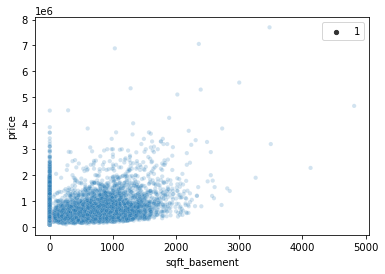

In [138]:
sns.scatterplot(data=df, x='sqft_basement', y='price', size=1, alpha=0.2);

## 'yr_built'

In [139]:
df.yr_built.describe()

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

Homes in our data were built between 1900 and 2015. Considering another feature is renovations and that is part of our business problem, it will be important to see the relationship between the build year, remodel year and sale year.

We don't need to do anything to this column

## 'yr_renovated'

There are some null values in this feature we saw at import that we will need to decide what to do with.

In [140]:
df.yr_renovated.value_counts(normalize=True)

0.0       0.958096
2014.0    0.004112
2003.0    0.001746
2013.0    0.001746
2007.0    0.001690
            ...   
1948.0    0.000056
1951.0    0.000056
1971.0    0.000056
1934.0    0.000056
1944.0    0.000056
Name: yr_renovated, Length: 70, dtype: float64

Over 95% of homes in our dataset have a value of 0.0, meaning the home has never been renovated. We assume that the null values are homes not renovated and set the value to 0.0

In [141]:
df['yr_renovated'].fillna(0.0, inplace=True)

It would be interesting to see the relationship between year built and year renovated, so we leave feature in for now.

It may be the case that we separate out the feature into one that is a numerical boolean (which makes sense, because 96% of homes have not been renovated).

It may also be the case that we not consider a home renovated if the renovation took place years before the home sale. It looks like there are some homes which were renovated in the 1930s and 1940s, they should not be considered renovated now.

Some early research shows that to be considered 'renovations' it should have occurred within 15 years, so we may use that information to make more features about renovation status.

## 'zipcode'

In [142]:
df.zipcode.value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
        ... 
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

There are 70 different zip codes in the county. Even the smallest zipcodes have 50 homes sold in the year our data was collected. 

We are going to leave the data in, and in order to do that we need to onehotencode it.

It may be worthwhile to look at converting zip codes into cities and look at the data collectively that way.

In [168]:
# import already done

# create temporary dataframe df_test with zipcode feature in it
df_test = df[['zipcode']].copy()

# create a onehotencoder, fit to df_test
ohe = OneHotEncoder().fit(df_test)

# create the array
onehotarray = ohe.transform(df_test).toarray()

# create a list of the sorted zipcodes to make column names
ordered_zipcodes = sorted(list(df.zipcode.unique()))

column_names = []
# generate column_names to match values, 'zip_{zipcode}'
for x in ordered_zipcodes:
    column_names.append(f'zip_{x}')

# create dataframe of array with correct column names
ohe_df = pd.DataFrame(onehotarray, columns=column_names)

# remove the column representing the most frequent value zipcode
ohe_df.drop(['zip_98103'], axis=1, inplace=True)

In [171]:
# concat the main dataframe df with the onehotencoded df we just made
df = pd.concat([df, ohe_df], axis=1)

# drop the original feature
df.drop(['zipcode'], axis=1, inplace=True)

## 'lat'

In [143]:
df.lat.describe()

count    21597.000000
mean        47.560093
std          0.138552
min         47.155900
25%         47.471100
50%         47.571800
75%         47.678000
max         47.777600
Name: lat, dtype: float64

Latitude goes from 47.155900 to 47.777600

We may use this data for mapping, no processing needed.

## 'long'

In [144]:
df.long.describe()

count    21597.000000
mean      -122.213982
std          0.140724
min       -122.519000
25%       -122.328000
50%       -122.231000
75%       -122.125000
max       -121.315000
Name: long, dtype: float64

Longitude goes from -122.519000 to -121.315000.

Combined with 'lat' we can plot the locations of our our sold homes on a map and look for patterns

## 'sqft_living15'

In [173]:
df.sqft_living15.describe()

count    21597.000000
mean      1986.620318
std        685.230472
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64

Per the data notes, these values are the square footage of interior housing living space for the nearest 15 neighbors. It looks to already be an average value, we do not need to engineer anything.

## 'sqft_lot15'

In [174]:
df.sqft_lot15.describe()

count     21597.000000
mean      12758.283512
std       27274.441950
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.000000
max      871200.000000
Name: sqft_lot15, dtype: float64

Again, based on data notes and experience with the dataset (and values from the other 'sqft_lot' feature), these values are the average lot for the 15 nearest neighbors to the property.

While not interesting in on it's own, it may help us categorize neighborhoods? We will see

## date extrapolation

Adding two features, for the month and year of the sale derived from the datetime feature 'date'. This is because we can't put a datetime object into a linear model (we found this out the hard way)

In [176]:
df['sale_month'] = df.date.map(lambda x: x.month)
df['sale_year'] = df.date.map(lambda x: x.year)

# Baseline model

In [177]:
# cannot use datetime object in linear regression. we pulled out the sale
# month and year from it as separate features for baseline model
# X (predictors) is all features BUT 'date' and 'price'
X = df.drop(['date', 'price'], axis=1)
y = df.price

In [178]:
# perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=0)

In [179]:
baseline_model = LinearRegression()
baseline_model.fit(X_train,y_train)

print('Single model fit score:', baseline_model.score(X_test,y_test))

Single model fit score: 0.8378526339605419


In [180]:
splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

baseline_scores = cross_validate(estimator=baseline_model, X=X_train,
                                 y=y_train, return_train_score=True, 
                                 cv=splitter)

print('------------------------------------')
print('Cross Validation Scores on X_train')
print('Train score:', baseline_scores['train_score'].mean())
print('Test score:', baseline_scores['test_score'].mean())

Train score: 0.8296672971516592
Test score: 0.836589486071557


In [181]:
X_train = sm.add_constant(X_train)
baseline_results = sm.OLS(y_train, X_train).fit()
baseline_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     822.3
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        22:24:08   Log-Likelihood:            -2.3080e+05
No. Observations:               17277   AIC:                         4.618e+05
Df Residuals:                   17173   BIC:                         4.626e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.181e+08   1.04e+07    -11.325      0.000   -1.39e+08   -9.77e+07
sqft_living     122.2122     14.857      8.226      0.000      93.091     151.334
sqft_lot          0.2127      0.042      5.070      0.000       0.130       0.295
waterfront     7.204e+05   1.49e+04     48.243      0.000    6.91e+05     7.5e+05
view           1.162e+05   4580.013     25.365      0.000    1.07e+05    1.25e+05
sqft_above       51.6296     15.000      3.442      0.001      22.229      81.031
sqft_basement    13.6242     14.787      0.921      0.357     -15.360      42.609
yr_built         70.9797     71.401      0.994      0.320     -68.973     210.932
yr_renovated     37.1403      3.409     10.894      0.000      30.458      43.823
lat            1.972e+05   6.74e+04      2.926      0.003    6.51e+04    3.29e+05
long          -2.496e+05   4.87e+04     -5.124      0.000   -3.45e+05   -1.54e+05
sqft_living15    17.2285      3.112      5.536      0.000      11.129      23.328
sqft_lot15       -0.1322      0.064     -2.074      0.038      -0.257      -0.007
bedrooms_1_2   1.122e+05   2.27e+04      4.944      0.000    6.77e+04    1.57e+05
bedrooms_3_4    1.16e+05   2.23e+04      5.210      0.000    7.23e+04     1.6e+05
bedrooms_5_6    9.67e+04   2.23e+04      4.331      0.000    5.29e+04     1.4e+05
bathrooms_1    1.556e+04   4179.442      3.722      0.000    7363.370    2.37e+04
bathrooms_3   -1.507e+04   2974.974     -5.067      0.000   -2.09e+04   -9241.670
floors_1       5.508e+04   8827.676      6.239      0.000    3.78e+04    7.24e+04
floors_2       4.127e+04   8101.775      5.094      0.000    2.54e+04    5.71e+04
condition_1   -8.917e+04   3.25e+04     -2.746      0.006   -1.53e+05   -2.55e+04
condition_2   -9717.8156   1.34e+04     -0.726      0.468    -3.6e+04    1.65e+04
condition_4    2.689e+04   3079.099      8.732      0.000    2.08e+04    3.29e+04
condition_5    7.876e+04   4816.613     16.351      0.000    6.93e+04    8.82e+04
grade_3         6.61e-09   1.55e-09      4.277      0.000    3.58e-09    9.64e-09
grade_4        5.392e+04   3.68e+04      1.466      0.143   -1.82e+04    1.26e+05
grade_5       -3930.6668    1.2e+04     -0.326      0.744   -2.75e+04    1.97e+04
grade_6       -6418.9727   4850.974     -1.323      0.186   -1.59e+04    3089.432
grade_8         2.65e+04   3443.999      7.694      0.000    1.97e+04    3.32e+04
grade_9        9.989e+04   5278.479     18.923      0.000    8.95e+04     1.1e+05
grade_10       2.194e+05   7608.891     28.834      0.000    2.04e+05    2.34e+05
grade_11       4.266e+05   1.15e+04     37.216      0.000    4.04e+05    4.49e+05
grade_12       8.406e+05   2.09e+04     40.190      0.000       8e+05    8.82e+05
grade_13       1.952e+06   4.52e+04     43.191      0.000    1.86e+06    2.04e+06
zip_98001     -2.721e+05   2.74e+04     -9.921   

Baseline model scores right about 83

## Exploring coefficient p-values

In [205]:
baseline_df = pd.DataFrame(baseline_results.pvalues.sort_values(ascending=True))

Now we can pull out all features whose coefficients' p-value was greater than the threshold (0.05)

In [212]:
high_pvalues = baseline_df[baseline_df[0] > 0.05]
high_pvalues.reset_index(inplace=True)
high_pvalues.columns = ['feature', 'p_value']
high_pvalues

We will likely be dropping other features due to multicollinearity, so here we will start a list of features to drop for our first model that we can add to in later sections

In [215]:
features_to_drop = list(high_pvalues.feature)

## Checking assumptions

Many of our assumptions require us have the residuals for the model. We will create a helper function to get the residuals to use in checking our assumptions for linear regression.

In [189]:
# helper function that takes three arguments: a linear regression model,
# a dataframe of predictors, and a dataframe of the target variable.
# It then returns a dataframe of the residuals based on calculated predictions

def residuals(model, predictors, target):
    
    # calculate predicted values from model
    y_hat = model.predict(predictors)
    
    # create dataframe with the target (real) and predicted values
    df_residuals = pd.DataFrame({'real': target, 'predicted': y_hat})
    
    # create a new feature of that dataframe 'residuals', which is the
    # difference of the real the the predicted
    df_residuals['residuals'] = (abs(df_residuals.real) - abs(df_residuals.predicted))
    
    return df_residuals

In [190]:
baseline_residuals = residuals(baseline_model, X_test, y_test)

In [ ]:
# sm.graphics.plot_regress_exog(baseline_results, 'sqft_living', fig=plt.figure(figsize=(12, 8)));

### Linearity

To satisfy the linearity assumption, we plot the real against the predicted vales. Linearity is satisfied if the resulting graph shows the values around the diagonal line.

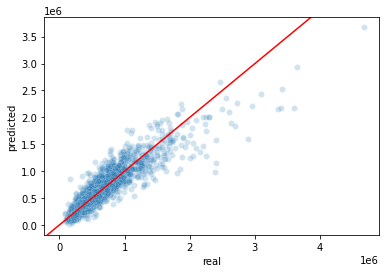

In [191]:
# g = sns.lmplot(data=baseline_residuals, x='real', y='predicted', aspect=1,
#           fit_reg=False)
# g.axline(yx1=(0,0), slope=1)

g = sns.scatterplot(data=baseline_residuals, x='real', y='predicted', alpha=0.2)
g.axline(xy1=(0,0), slope=1, color='red')
g.set_aspect(aspect='auto')

The relationship is not terrible, the model does not perform well as price increases, but that's expected, we have not changed our data and have few high priced homes to train on. This gives us more cause to consider removing outliers from some features, like sqft_living and/or price.

### Independence

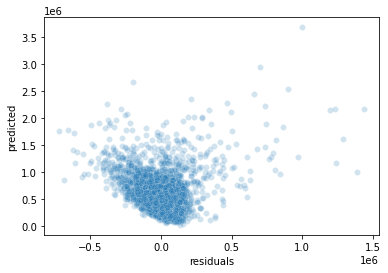

In [192]:
sns.scatterplot(data=baseline_residuals, x='residuals', y='predicted',
               alpha=0.2);

### Normality

Check the distribution of the residuals, using a histogram and/or QQ plot. Can also be checked with Kolmogorov-Smirnov test.

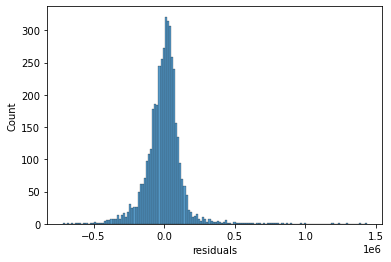

In [193]:
sns.histplot(data=baseline_residuals, x='residuals');

### Homoskedacity

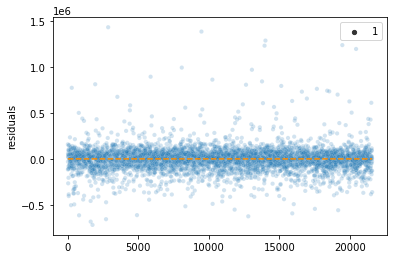

In [194]:
sns.scatterplot(x=baseline_residuals.index, y=baseline_residuals.residuals,
               size=1, alpha=0.2)
plt.plot(np.repeat(0, baseline_residuals.index.max()), color='darkorange',
         linestyle='--');

## Identify multicollinearity

In [195]:
# We already defined X as df_final without date (because of datetime issues),
# and without price (the target)
test_df = X.corr().abs().stack().reset_index().sort_values(0,ascending=False)
test_df['pairs'] = list(zip(test_df.level_0, test_df.level_1))
test_df.set_index(['pairs'], inplace=True)
test_df.drop(['level_0', 'level_1'], axis=1, inplace=True)
test_df.columns = ['mc']
test_df[(test_df.mc > 0.75) & (test_df.mc < 1)]

,mc
pairs,
"(floors_2, floors_1)",0.942250
"(floors_1, floors_2)",0.942250
"(sqft_above, sqft_living)",0.876448
"(sqft_living, sqft_above)",0.876448
"(sale_year, sale_month)",0.782325
"(sale_month, sale_year)",0.782325
"(sqft_living, sqft_living15)",0.756402
"(sqft_living15, sqft_living)",0.756402


So we have some multicollinearity between the floors features. Likely what happened here is we have too many bins. 
> We will drop floors_2, leaving just floors_1 as a predictor. If the value is 0, means nothing more than the home has more then 1.5 floors.

We have multicollinearity between sqft_living and two other features:
- sqft_above
- sqft_living15

> We have already discussed how to engineer a feature related to basements, so I think we can just drop sqft_above safely. As for sqft_living15, we will need to look into this. Maybe we can engineer some kind of feature that shows how similar in size the home is compared to nearby homes in neighborhood?


Sales month and year also have multicollinearity.

> Seeing as the year will either be 2014 or 2015, we will drop sales year and keep sales month




In [217]:
features_to_drop.extend(['floors_2', 'sqft_above', 'sale_year'])

# Model v1

We have been keeping track of features to drop so far:
- based on the p-value of the coefficient from the OLS baseline model and
- the test for multicollinearity that was performed

We need to add to that list the date and price to ensure that all necessary columns are dropped for our next model.

In [220]:
features_to_drop.extend(['date','price'])

In [221]:
X = df.drop(features_to_drop, axis=1)
y = df.price

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=0)

model_v1 = LinearRegression()
model_v1.fit(X_train,y_train)

print('Single model fit score:', model_v1.score(X_test,y_test))

splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

baseline_scores = cross_validate(estimator=model_v1, X=X_train,
                                 y=y_train, return_train_score=True, 
                                 cv=splitter)

print('------------------------------------')
print('Cross Validation Scores on X_train')
print('Train score:', baseline_scores['train_score'].mean())
print('Test score:', baseline_scores['test_score'].mean())

Single model fit score: 0.8354534466011336
------------------------------------
Cross Validation Scores on X_train
Train score: 0.8272988343033127
Test score: 0.8350739397700192


In [223]:
model_v1.coef_

array([ 1.59065548e+02,  2.21657486e-01,  7.18133074e+05,  1.09129876e+05,
        3.65609122e+01,  1.62042575e+05, -2.79647952e+05,  2.20093503e+01,
       -1.19826019e-01,  1.11668971e+05,  1.17771128e+05,  9.75432125e+04,
        2.03327966e+04, -1.69274601e+04, -6.64688019e+02, -8.72828064e+04,
        2.49795102e+04,  7.40950869e+04, -7.01984391e-08,  2.70724901e+04,
        1.05502457e+05,  2.28175221e+05,  4.39628418e+05,  8.58045652e+05,
        1.98342458e+06, -2.70127335e+05, -2.42187676e+05, -2.81906757e+05,
        4.81608328e+05, -3.58908061e+04, -3.22615516e+04, -1.42698450e+05,
       -1.83834229e+05, -1.15954265e+05, -1.50876968e+05, -1.84235984e+05,
       -3.26482962e+05, -4.17916727e+04, -7.40370791e+04, -2.01056325e+05,
       -2.47796904e+05, -2.39698711e+05, -2.78807044e+05,  5.83665187e+04,
       -1.12171602e+05, -1.71313578e+05,  9.21640397e+05,  2.03290398e+05,
       -2.25205163e+05, -5.36099318e+04, -4.49962106e+04, -3.80732069e+04,
       -2.32627967e+05, -

In [224]:
X_train = sm.add_constant(X_train)
model_v1_results = sm.OLS(y_train, X_train).fit()
model_v1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     947.9
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        22:57:56   Log-Likelihood:            -2.3091e+05
No. Observations:               17277   AIC:                         4.620e+05
Df Residuals:                   17188   BIC:                         4.627e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.178e+07   3.21e+06    -13.031      0.000   -4.81e+07   -3.55e+07
sqft_living     159.0655      2.628     60.517      0.000     153.914     164.218
sqft_lot          0.2217      0.042      5.263      0.000       0.139       0.304
waterfront     7.181e+05    1.5e+04     47.874      0.000    6.89e+05    7.48e+05
view           1.091e+05   4543.507     24.019      0.000       1e+05    1.18e+05
yr_renovated     36.5609      3.280     11.146      0.000      30.132      42.990
lat             1.62e+05      6e+04      2.701      0.007    4.44e+04     2.8e+05
long          -2.796e+05   2.89e+04     -9.688      0.000   -3.36e+05   -2.23e+05
sqft_living15    22.0094      3.076      7.155      0.000      15.980      28.039
sqft_lot15       -0.1198      0.064     -1.870      0.061      -0.245       0.006
bedrooms_1_2   1.117e+05   2.28e+04      4.895      0.000     6.7e+04    1.56e+05
bedrooms_3_4   1.178e+05   2.24e+04      5.261      0.000    7.39e+04    1.62e+05
bedrooms_5_6   9.754e+04   2.25e+04      4.344      0.000    5.35e+04    1.42e+05
bathrooms_1    2.033e+04   3935.933      5.166      0.000    1.26e+04     2.8e+04
bathrooms_3   -1.693e+04   2975.536     -5.689      0.000   -2.28e+04   -1.11e+04
floors_1       -664.6880   3242.333     -0.205      0.838   -7019.991    5690.615
condition_1   -8.728e+04   3.24e+04     -2.694      0.007   -1.51e+05   -2.38e+04
condition_4    2.498e+04   2962.018      8.433      0.000    1.92e+04    3.08e+04
condition_5     7.41e+04   4634.540     15.988      0.000     6.5e+04    8.32e+04
grade_3         6.96e-07   2.07e-08     33.669      0.000    6.55e-07    7.37e-07
grade_8        2.707e+04   3382.271      8.004      0.000    2.04e+04    3.37e+04
grade_9        1.055e+05   5132.545     20.556      0.000    9.54e+04    1.16e+05
grade_10       2.282e+05   7417.588     30.761      0.000    2.14e+05    2.43e+05
grade_11       4.396e+05   1.12e+04     39.317      0.000    4.18e+05    4.62e+05
grade_12        8.58e+05   2.07e+04     41.433      0.000    8.17e+05    8.99e+05
grade_13       1.983e+06   4.52e+04     43.883      0.000    1.89e+06    2.07e+06
zip_98001     -2.701e+05   2.25e+04    -11.981      0.000   -3.14e+05   -2.26e+05
zip_98002     -2.422e+05   2.34e+04    -10.349      0.000   -2.88e+05   -1.96e+05
zip_98003     -2.819e+05   2.36e+04    -11.957      0.000   -3.28e+05   -2.36e+05
zip_98004      4.816e+05   1.08e+04     44.595      0.000     4.6e+05    5.03e+05
zip_98006     -3.589e+04   9723.812     -3.691      0.000    -5.5e+04   -1.68e+04
zip_98007     -3.226e+04   1.57e+04     -2.056      0.040    -6.3e+04   -1508.862
zip_98010     -1.427e+05   2.36e+04     -6.040      0.000   -1.89e+05   -9.64e+04
zip_98011     -1.838e+05   1.51e+04    -12.215      0.000   -2.13e+05   -1.54e+05
zip_98014      -1.16e+05   2.08e+04     -5.565   

In [226]:
model_v1_df = pd.DataFrame(model_v1_results.pvalues.sort_values(ascending=True))

Now we can pull out all features whose coefficients' p-value was greater than the threshold (0.05)

In [227]:
high_pvalues = model_v1_df[model_v1_df[0] > 0.05]
high_pvalues.reset_index(inplace=True)
high_pvalues.columns = ['feature', 'p_value']
high_pvalues

,feature,p_value
0,zip_98024,0.050802
1,sqft_lot15,0.061470
2,floors_1,0.837572


# Feature Engineering

## Renovation

Set up new dataframe 'renovation_features' to hold engineered features before joining in with original features.

We are first working on the renovation status, so we will need some features: yr_built, yr_renovated, and sale_year

In [ ]:
renovation_features = df[['yr_built', 'yr_renovated', 'sale_year']].copy()

During research on renovations, it seems like a general industry standard is that a home is considered renovated if the renovation took place within 15 years. We are engineering a new feature 'is_renovated' as a boolean, with 1 being the home is renovated within 15 years of sale, and 0 being either never renovated or renovations took place more than 15 years before sale.

In [ ]:
def renovation_status(df):
    if df.yr_renovated == 0.0:
        return 0
    else:
        if (df.sale_year - df.yr_renovated) > 15:
            return 0
        else:
            return 1
        
renovation_features['is_renovated'] = renovation_features.apply(renovation_status, axis=1)
renovation_features.drop(renovation_features.iloc[:, 0:3], axis=1, inplace=True)

In [ ]:
renovation_features.is_renovated.value_counts()

Our renovation feature is now a boolean representing homes that were renovated with 15 years of the sale.

> The feature resides in a dataframe 'renovation_features' so that we can concat it into our next iteration of features to be modeled

## Basement

The sqft_basement poses some interesting questions. I think first we want a column to see if there is a basement or not

In [ ]:
basement_features = df[['sqft_living', 'sqft_basement']].copy()

In [ ]:
basement_features

In [ ]:
basement_features['has_basement'] = basement_features.sqft_basement.map(lambda x: 1 if x > 0 else 0)

In [ ]:
basement_features

In [ ]:
def percent_basement(df):
    if df.has_basement == False:
        return 0
    else:
        return round(((df.sqft_basement / df.sqft_living) * 100), 2)

In [ ]:
basement_features['basement_percent'] = basement_features.apply(percent_basement, axis=1)

In [ ]:
basement_features.has_basement.value_counts(normalize=True)

In [ ]:
basement_features[basement_features.basement_percent > 0].basement_percent.describe()

In [ ]:
sns.histplot(data=basement_features[basement_features.basement_percent > 0], x='basement_percent')

In our dataset, 60% of homes have no basement at all.

Of those that have basements, the above histogram shows the binned percent of sqft_living that is made up of sqft_basement.

It looks like we have a case for a feature that will show if the percent of the home that is basement is.

In [ ]:
basement_features.drop(basement_features.iloc[:, 0:3], axis=1, inplace=True)

In [ ]:
basement_features

## Zipcode

In [ ]:
zipcode_features = df[['zipcode']].copy()

There at 70 different zipcode values in our dataset. We want to try and create a new feature that takes zipcodes and matches them up with cities in our area.

In [ ]:
# https://zipdatamaps.com/king-wa-county-zipcodes
zip_city = pd.read_csv('data\zip_city.csv')

zipcode_features = pd.merge(left=zipcode_features, right=zip_city, on='zipcode', how='left')

In [ ]:
zipcode_features

zipcode_features can be merged into the larger dataframe to associate a home with a city instead of just a zipcode.

Let's explore this a bit more.

In [ ]:
homes_by_zip = zipcode_features.groupby('city').count()
homes_by_zip.reset_index(inplace=True)
homes_by_zip.columns = ['city', 'count']

In [ ]:
homes_by_zip

In [ ]:
homes_by_zip.sort_values(by='count', ascending=False)

So instead of 70 different zipcodes for a feature, we can have 24 different city names.

Lets put in the features we engineered for renovation, basement, and zipcode

# Model version 2, adding in engineered features

In [ ]:
df_v2 = pd.concat([df_final, renovation_features, basement_features,
                   zipcode_features], axis=1)

In [ ]:
df_v2.columns

In [ ]:
X = df_v2.drop(['date', 'price', 'bathrooms', 'sqft_living', 'floors',
                'sqft_above', 'sqft_basement', 'grade', 'sale_year',
                'yr_renovated', 'sqft_living15', 'city'], axis=1)
y = df_final.price

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=0)

model_v2 = LinearRegression()
model_v2.fit(X_train,y_train)

print('Single model fit score:', model_v1.score(X_test,y_test))

splitter = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

baseline_scores = cross_validate(estimator=model_v2, X=X_train,
                                 y=y_train, return_train_score=True, 
                                 cv=splitter)

print('Train score:', baseline_scores['train_score'].mean())
print('Test score:', baseline_scores['test_score'].mean())

# Identify outliers

Assuming we are keeping sqft_living as a feature from 4.1, the box plot during EDA showed lots of outliers. Going to see if we can identify outliers that we can drop.

In [ ]:
df_version2 = df_final.copy()

In [ ]:
df_version2

We suspect we will have no lower outliers, but we will check both anyway

In [ ]:
upper_limit = df_version2.sqft_living.mean() + 3*df_version2.sqft_living.std()
lower_limit = df_version2.sqft_living.mean() - 3*df_version2.sqft_living.std()

In [ ]:
upper_limit

Using z-scores above 3, we will remove all homes with sqft_living over 4834.64

In [ ]:
df_version2 = df_version2[df_version2.sqft_living < upper_limit].copy()

In [ ]:
df_version2

In [ ]:
df_version2.sqft_living.describe()

In [ ]:
len(df_final) - len(df_version2)

248 homes were considered outliers in the sqft_living column

In [ ]:
# cannot use datetime object in linear regression. we pulled out the sale
# month and year from it as separate features for baseline model
X = df_version2.drop(['date', 'price'], axis=1)
y = df_version2.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=0)

model_version2 = LinearRegression()
model_version2.fit(X_train,y_train)
model_version2.score(X_test,y_test)

Also going to try and removing the features identified to have multicollinearity

In [ ]:
df_version2.drop(['sqft_above','grade','sqft_living15','bathrooms'], axis=1,
                inplace=True)

In [ ]:
# cannot use datetime object in linear regression. we pulled out the sale
# month and year from it as separate features for baseline model
X = df_version2.drop(['date', 'price'], axis=1)
y = df_version2.price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=0)

model_version3 = LinearRegression()
model_version3.fit(X_train,y_train)
model_version3.score(X_test,y_test)

In [ ]:
df_version2[(df_version2.sale_year - df_version2.yr_renovated) <= 15]

In [ ]:
df_version2[((df_version2.sale_year - df_version2.yr_renovated) > 15) & (df.yr_renovated != 0.0)]

In [ ]:
df_version2[df_version2.yr_renovated == 0.0]

In [ ]:
df_version2['is_renovated'] = 0

In [ ]:
# df_version2['is_renovated'] = df_version2.is_renovated.map(lambda x: 1 if ((x.sale_year - x.yr_renovated) <= 15))

# Log scaling 'price' feature

In [ ]:
log_price = np.log(df.price)

In [ ]:
df_log = pd.DataFrame([])

In [ ]:
df_log['log_price'] = np.log(df.price)

In [ ]:
sns.histplot(data=df_log, x='log_price', bins=30);

In [ ]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

df_log_final = df_log.apply(normalize)

In [ ]:
sns.histplot(data=df_log_final, x='log_price', bins=30);

Results from correlated numerical data, focus on exploring how to transform/normalize these 4 (and price)

- sqft_living    0.701917
- bathrooms      0.525906
- bedrooms       0.308787
- floors         0.256804

In [ ]:
df.sqft_living.describe()